# Evaluation of Tweets about Covid-19 with Sentiment Analysis and Deep Learning Models Using NLP

# Content
1. [Including Libraries](#1)
2. [Including the Dataset](#2)
3. [Data Analyze](#3)
4. [Distributing Classes](#4)
    * [Distributing Train Datas](#5)
    * [Distributing Test Datas](#6)
5. [Data Processing](#7)
    * [Data Cleaning](#8)
    * [Tokenization](#9)
6. [Training Process](#10)
    * [Artificial Neural Network](#11)
    * [Convolutional Neural Network](#12)
    * [Recurrent Neural Network](#13)
    * [Long Short Term Memory](#14)
7. [Beginning Train Process](#15)
8. [Drawing Charts](#16)
    * [Accuracy Charts](#17)
    * [Loss Charts](#18)
9. [Cleaning Test Datas](#19)
10. [Testing Models and Test Results](#20)
    * [Confusion Matrix](#21)

<a id="1"></a>
# Including Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import seaborn as sns


from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
import torch
import re
import copy
import torch.nn as nn
from torch.nn import Embedding,Conv1d
from pathlib import Path
%pip install tqdm
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn,optim
from tqdm.notebook import tqdm

from torch.optim import Adam

import os
for Project, _, test in os.walk('/Project/test'):
    for filename in test:
        print(os.path.join(Project, filename))


Note: you may need to restart the kernel to use updated packages.


<a id="2"></a>
# Including the Dataset

In [ ]:
root_path = Path("data")  
train_df = pd.read_csv(root_path / "Corona_NLP_train.csv",encoding='latin')  
test_df = pd.read_csv(root_path / "Corona_NLP_test.csv",encoding='latin')

<a id="3"></a>
# Data Analyze

In [110]:
train_df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


* Here we see the attributes in the dataset and the first 10 data belonging to them.

In [111]:
print(f'Number of samples in the training dataset: {len(train_df)}')
print(f'Number of samples in the test dataset: {len(test_df)}')

Number of samples in the training dataset: 41157
Number of samples in the test dataset: 3798


* While there are 41157 pieces of data in total in the Training dataset, there are 3798 pieces of data in total in the Test dataset.

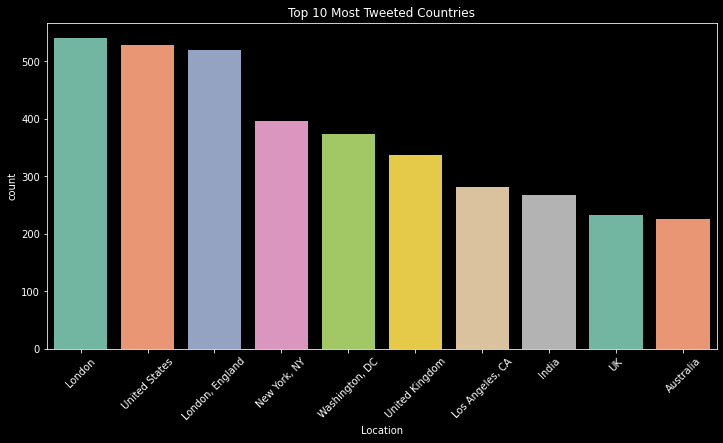

In [112]:
plt.figure(figsize=(12,6))
plt.title('Top 10 Most Tweeted Countries')
countries=sns.countplot(x='Location',data=train_df,order=train_df['Location'].value_counts().index[:10],palette='Set2')
countries.set_xticklabels(countries.get_xticklabels(),rotation=45)
plt.show()

* Chart showing from which country the tweets in the dataset were posted.
* Only the top 10 most tweeted countries are shown here.

In [113]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

* We learn the number of empty data in the dataset.
* Here we see that there are 8590 empty data in the '*Location*' attribute. However, since this attribute will not be used in the process, we do not need to fill in or remove the empty data.

In [ ]:
dist_train=train_df['Sentiment'].value_counts()
dist_test=test_df['Sentiment'].value_counts()
# We get the distribution of the "Sentiment" attribute, called the class tag, in the training and test dataset.
def distribution_plot(x,y,name,color):
    fig=go.Figure([go.Bar(x=x,y=y,marker={'color':color})])
    fig.update_layout(title_text=name)
    fig.show()

In [115]:
distribution_plot(x=dist_train.index,y=dist_train.values,name='Training Dataset Distribution of Data',color='#DC3912')

* Graph showing the number of classes in the emotionality attribute in the training dataset
* In total in the dataset:
     * 11422 pcs Positive
     * 9917 pieces of Negative
     * 7713 pcs Natural
     * 6624 Extremely Positive
     * 5481 pcs Extremely Negative
* tweets are included.

In [116]:
distribution_plot(x=dist_test.index,y=dist_test.values,name='Test Dataset Distribution of Data',color='#0099C6')

* Graph showing the number of classes in the emotionality attribute in the training dataset
* In total in the dataset:
     * 11422pcs Positive
     * 9917 pieces of negative
     * 7713 pcs Natural
     * 6624 Extremely Positive
     * 5481 pcs Extremely Negative
* tweets are included.

In [117]:
print(train_df['Sentiment'].unique())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


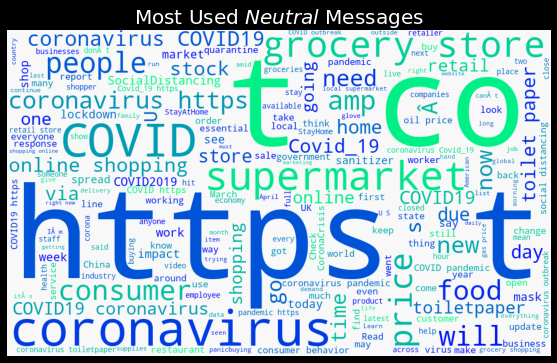

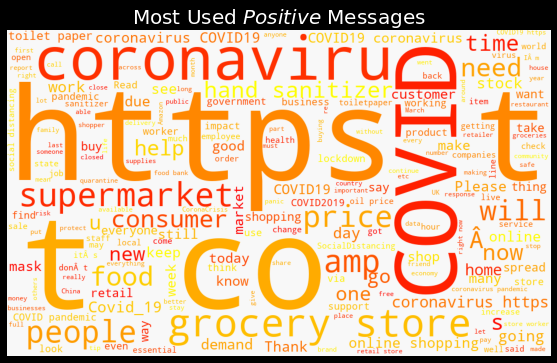

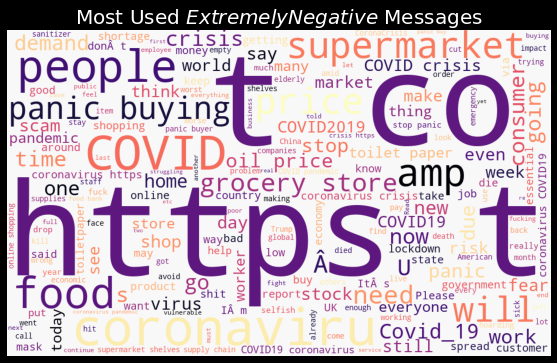

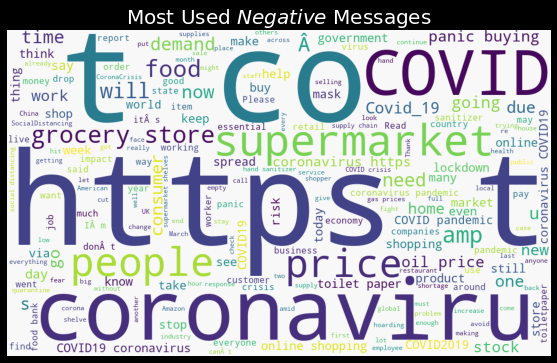

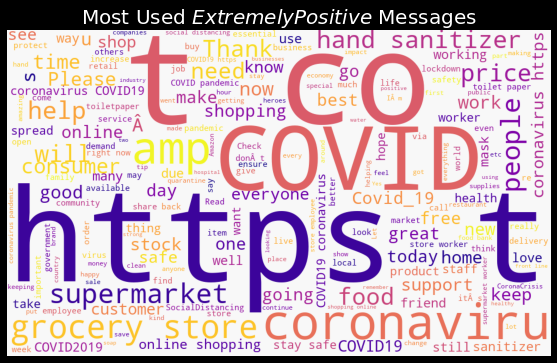

In [118]:
sentiments=train_df['Sentiment'].unique()
color_maps=['winter','autumn','magma','viridis','plasma']
for label,cmap in zip(sentiments,color_maps):
    text=train_df.query('Sentiment==@label')['OriginalTweet'].str.cat(sep=' ')
    plt.figure(figsize=(10,6))
    wc=WordCloud(width=1000,height=600,background_color='#f8f8f8',colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f'Most Used ${label}$ Messages',size=20)
    plt.show()

* Graphs of the most used words in tweets in the dataset by class tags.
* Because there are too many links in tweets, the word "https" has come to the fore in general.

<a id="4"></a>
# Distributing Classes

<a id="5"></a>
## Distributing Training Datas

In [119]:
X=train_df['OriginalTweet'].copy()
y=train_df['Sentiment'].copy()

In [120]:
X.head(10)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

* Since the data we will train in the neural network will only consist of tweets and class tags, we do not take anything other than the "OriginalTweet" and "Sentiment" attributes as training or test data.

In [ ]:
datas=[0.814112663269043,0.838072657585144,0.8412322402000427,0.8528172969818115]

<a id="6"></a>
## Distributing Test Datas

In [122]:
X_test=test_df['OriginalTweet'].copy()
y_test=test_df['Sentiment'].copy()

In [123]:
X_test.head(10)

0    TRENDING: New Yorkers encounter empty supermar...
1    When I couldn't find hand sanitizer at Fred Me...
2    Find out how you can protect yourself and love...
3    #Panic buying hits #NewYork City as anxious sh...
4    #toiletpaper #dunnypaper #coronavirus #coronav...
5    Do you remember the last time you paid $2.99 a...
6    Voting in the age of #coronavirus = hand sanit...
7    @DrTedros "We canÂt stop #COVID19 without pro...
8    HI TWITTER! I am a pharmacist. I sell hand san...
9    Anyone been in a supermarket over the last few...
Name: OriginalTweet, dtype: object

In [124]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/shawnyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a id="7"></a>
# Data Processing

<a id="8"></a>
## Cleaning

In [125]:
lemma=nlp.WordNetLemmatizer()
def data_cleaner(tweet):
    tweet=re.sub(r'http\S+', ' ',tweet)
    
    tweet=re.sub('\[.*?\]',' ',tweet)
    
    tweet=re.sub(r'<.*?>',' ',tweet)
    
    tweet=re.sub(r'\d+',' ', tweet)
    
    tweet=re.sub(r'#\w+',' ',tweet)
    
    tweet=re.sub(r'@\w+', ' ',tweet)
    
    tweet=re.sub('[^a-zA-Z]', ' ', tweet)
    
    tweet=tweet.lower()
    tweet=nltk.word_tokenize(tweet,'english')
    tweet=[word for word in tweet if not word in set(stopwords.words('english'))]
    tweet=[lemma.lemmatize(word) for word in tweet]
    tweet=' '.join(tweet)
    return tweet

In [126]:
import string 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# stop word
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
stop_word = stopwords.words('english')
# keep no and not in the tweet
stop_word.remove('not')
stop_word.remove('no')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shawnyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shawnyang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shawnyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shawnyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [127]:
X_cleaned=X.apply(data_cleaner)
X_cleaned.head(10)

0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    food stock one empty please panic enough food ...
4    ready go supermarket outbreak paranoid food st...
5    news region first confirmed covid case came su...
6    cashier grocery store sharing insight prove cr...
7                   supermarket today buy toilet paper
8    due covid retail store classroom atlanta open ...
9    corona prevention stop buy thing cash use onli...
Name: OriginalTweet, dtype: object

In [128]:
data_frame=pd.DataFrame({
    'Tweets':X_cleaned,
    'Sentiment':y
})

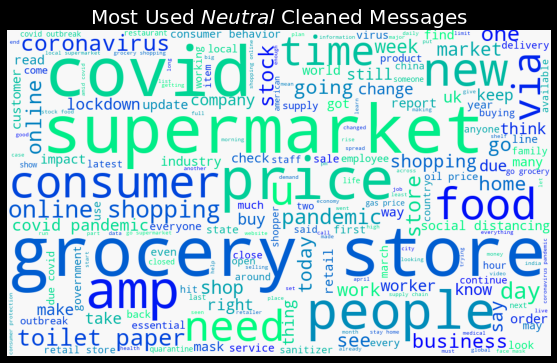

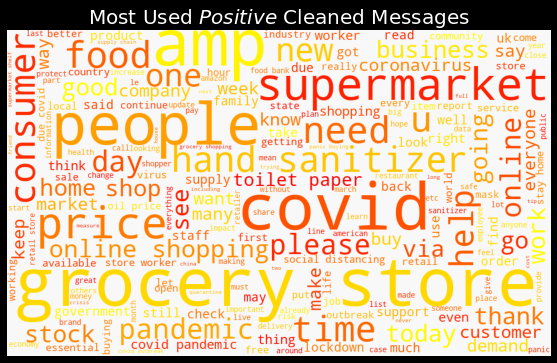

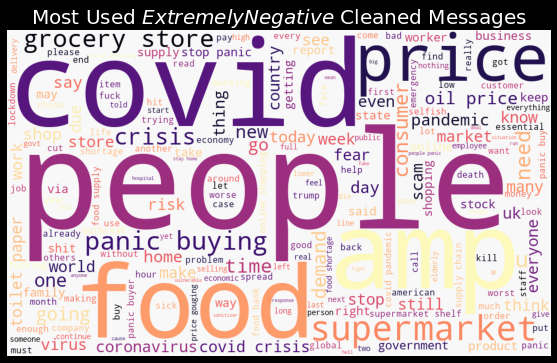

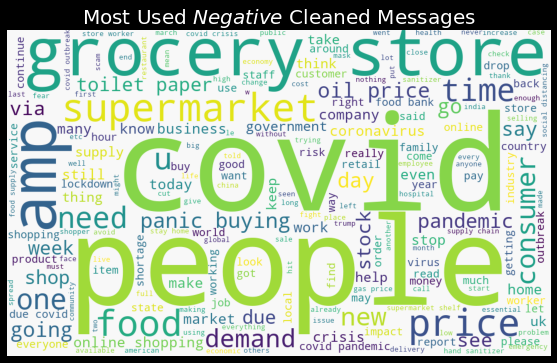

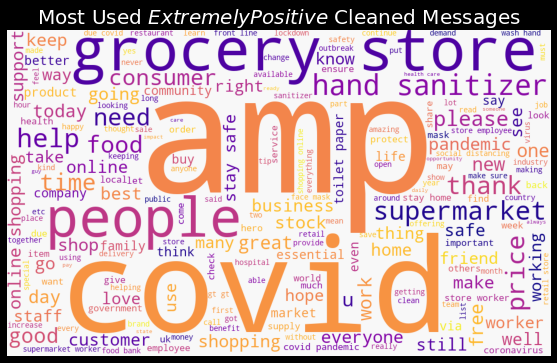

In [129]:
sentiments=data_frame['Sentiment'].unique()
color_maps=['winter','autumn','magma','viridis','plasma']
for label,cmap in zip(sentiments,color_maps):
    text=data_frame.query('Sentiment==@label')['Tweets'].str.cat(sep=' ')
    plt.figure(figsize=(10,6))
    wc=WordCloud(width=1000,height=600,background_color='#f8f8f8',colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.imsave(f'{label}.png',wc)
    plt.axis('off')
    plt.title(f'Most Used ${label}$ Cleaned Messages',size=20)
    plt.show()

* We apply the "data_cleaner" function that we wrote above to the variable X, that is, the variable with the tweets, and we clean the content of the tweets.
* When we compare the tweets we see at the top with the tweets we see here, we understand that there is a big difference.

<a id="9"></a>
## Tokenization

* We can shorten the training process or enable the artificial neural network model to learn better by combining similar or identical words and expressing them with a numeric character before training the tweets we clean with the artificial neural network.

In [130]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X=tokenizer.texts_to_sequences(X_cleaned)
vocab_size=len(tokenizer.word_index)+1
print(f'Word Size : {vocab_size}')
print('\nSample:\n')
print(f'Original Sentence :\n{X_cleaned[10]}')
print(f'\nAfter Tokenization :\n{X[10]}')
X=pad_sequences(X,padding='post')
print(f'\nAfter Padding :\n{X[10]}')

Word Size : 28932

Sample:

Original Sentence :
month crowding supermarket restaurant however reducing hour closing mall mean everyone using entrance dependent single supermarket

After Tokenization :
[139, 3341, 4, 187, 719, 1429, 108, 477, 943, 210, 71, 236, 2036, 4096, 648, 4]

After Padding :
[ 139 3341    4  187  719 1429  108  477  943  210   71  236 2036 4096
  648    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


* As we can see here, the original sentence is "month crowding supermarket restaurant however reducing hour closing mall mean everyone using entrance dependent single supermarket", but after the tokenization process, we see it expressed in numerical characters as above.
* Padding is applied to make the data suitable for the neural network.

In [131]:
encoding={
    'Extremely Negative':0,
    'Negative':0,
    'Neutral':1,
    'Positive':2,
    'Extremely Positive':2
}
labels=['Negative','Neutral','Positive']
y.replace(encoding,inplace=True)

* Here we convert the class labels in the dataset into numeric expressions. While doing this, we reduce the class labels from 5 to 3.
* We get 3 class labels as Positive, Neural and Negative. In this way, the artificial neural network will make a decision much easier.

<a id="10"></a>
# Training Process

In [132]:
EPOCH=2
BATCH_SIZE=32
VALIDATION_SPLIT=0.12
EMBEDDING_DIMS=16

<a id="11"></a>
## Artificial Neural Network(ANN)

In [133]:
modelANN=tf.keras.Sequential([
    L.Embedding(vocab_size, EMBEDDING_DIMS, input_length=X.shape[1]),
    L.Dense(512,activation='relu'),
    L.Dense(512,activation='relu'),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64,activation='relu'),
    L.Dropout(0.4),
    L.Dense(3,activation='softmax')
])
modelANN.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
modelANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            462912    
                                                                 
 dense (Dense)               (None, 45, 512)           8704      
                                                                 
 dense_1 (Dense)             (None, 45, 512)           262656    
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                        

2022-12-03 10:26:32.713781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id="12"></a>
## Convolutional Neural Network(CNN)

In [134]:
modelCNN=tf.keras.Sequential([
    L.Embedding(vocab_size, EMBEDDING_DIMS, input_length=X.shape[1]),
    L.Conv1D(512,activation='relu',kernel_size=5,padding='Same'),
    L.MaxPool1D(),
    L.Conv1D(512,activation='relu',kernel_size=3,padding='Same'),
    L.MaxPool1D(),
    L.Dropout(0.4),
    L.GlobalAveragePooling1D(),
    L.Dense(64,activation='relu'),
    L.Dropout(0.4),
    L.Dense(3,activation='softmax')
])
modelCNN.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 45, 16)            462912    
                                                                 
 conv1d (Conv1D)             (None, 45, 512)           41472     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 512)           786944    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 512)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 11, 512)          

<a id="13"></a>
## Recurrent Neural Network(RNN)

In [135]:
modelRNN=tf.keras.Sequential([
    L.Embedding(vocab_size, EMBEDDING_DIMS, input_length=X.shape[1]),
    L.SimpleRNN(512,return_sequences=True,activation='relu'),
    L.SimpleRNN(512,return_sequences=True,activation='relu'),
    L.GlobalAveragePooling1D(),
    L.Dense(64,activation='relu'),
    L.Dropout(0.4),
    L.Dense(3,activation='softmax')
])
modelRNN.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
modelRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 45, 16)            462912    
                                                                 
 simple_rnn (SimpleRNN)      (None, 45, 512)           270848    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 45, 512)           524800    
                                                                 
 global_average_pooling1d_1   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

<a id="14"></a>
## Long Short Term Memory(LSTM)

In [136]:
modelLSTM=tf.keras.Sequential([
    L.Embedding(vocab_size, EMBEDDING_DIMS, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(256,return_sequences=True)),
    L.Bidirectional(L.LSTM(256,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64,activation='relu'),
    L.Dropout(0.4),
    L.Dense(3,activation='softmax')
])
modelLSTM.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])
modelLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 16)            462912    
                                                                 
 bidirectional (Bidirectiona  (None, 45, 512)          559104    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 45, 512)          1574912   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

<a id="15"></a>
# Beginning Train Process

In [138]:
# print('Artificial Neural Network Model\n')
# historyANN=modelANN.fit(X, y, epochs=EPOCH, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE)
print('Convolutional Neural Network Model\n')
historyCNN=modelCNN.fit(X, y, epochs=EPOCH, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE)
# print('Recurrent Neural Network Model\n')
# historyRNN=modelRNN.fit(X, y, epochs=EPOCH, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE)
# print('Long Short Term Memory Model\n')
# historyLSTM = modelLSTM.fit(X, y, epochs=EPOCH, validation_split=VALIDATION_SPLIT, batch_size=BATCH_SIZE)

Convolutional Neural Network Model

Epoch 1/2
1132/1132 [==============================] - 60s 50ms/step - loss: 0.6365 - accuracy: 0.7371 - val_loss: 0.4085 - val_accuracy: 0.8569
Epoch 2/2
1132/1132 [==============================] - 67s 59ms/step - loss: 0.3594 - accuracy: 0.8839 - val_loss: 0.4042 - val_accuracy: 0.8674


In [139]:
history={ 'CNN':historyCNN}

In [140]:
model_names=['Convolutional Neural Network']

<a id="16"></a>
# Drawing Charts

<a id="17"></a>
## Accuracy Charts

In [141]:
for i,hist in enumerate(history):
    fig=px.line(history[hist].history,y=['accuracy','val_accuracy'],
               labels={'index':'epoch','value':'accuracy'},
               title=f'According to the epoch {model_names[i]} accuracy and validation accuracy chart for the model')
    fig.show()

<a id="18"></a>
## Loss Charts

In [142]:
for i,hist in enumerate(history):
    fig=px.line(history[hist].history,y=['loss','val_loss'],
               labels={'index':'epoch','value':'loss'},
               title=f'According to the epoch {model_names[i]} loss and validation loss chart for the model')
    fig.show()

<a id="19"></a>
# Cleaning Test Datas

In [ ]:
X_test=X_test.apply(data_cleaner)
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,padding='post')
y_test.replace(encoding,inplace=True)

* Here we need to clean the test data just like we do the training data. Because test data also contains unnecessary characters like training data.
* For this, we apply the "data_cleaner" function we defined above to the test data and change the "y_test", that is, the class labels of the test data, to 0-1-2 as we do to the training data.

In [ ]:
models={'ANN':modelANN, 'CNN':modelCNN, 'RNN':modelRNN, 'LSTM':modelLSTM}

In [ ]:
models

{'ANN': <keras.engine.sequential.Sequential at 0x7fa880de4990>,
 'CNN': <keras.engine.sequential.Sequential at 0x7fa873fddf10>,
 'RNN': <keras.engine.sequential.Sequential at 0x7fa873fdd810>,
 'LSTM': <keras.engine.sequential.Sequential at 0x7fa88132dc50>}

In [ ]:
classes={}
for i,model in enumerate(models):
    prediction=models[model].predict(X_test)
    classes[model]=np.argmax(prediction,axis=1)

In [ ]:
classes

{'ANN': array([0, 2, 2, ..., 1, 0, 2]),
 'CNN': array([0, 2, 2, ..., 1, 0, 2]),
 'RNN': array([0, 2, 2, ..., 1, 0, 2]),
 'LSTM': array([0, 2, 2, ..., 1, 0, 2])}

<a id="20"></a>
# Testing Models and Test Results

In [ ]:
for i,model in enumerate(models):
    print(model)
    loss,accuracy=models[model].evaluate(X_test,y_test,verbose=0)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

ANN
Test Loss: 0.4946623742580414
Test Accuracy: 0.8146392703056335
CNN
Test Loss: 0.45230633020401
Test Accuracy: 0.8449183702468872
RNN
Test Loss: 0.4902232885360718
Test Accuracy: 0.8264876008033752
LSTM
Test Loss: 0.45975053310394287
Test Accuracy: 0.8488678336143494


<a id="21"></a>
## Confusion Matrix

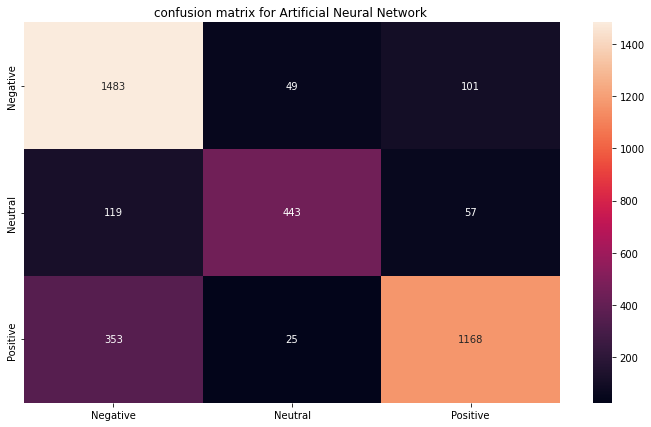

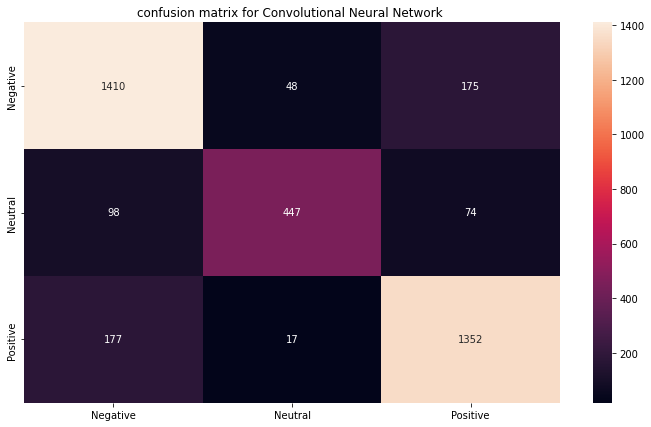

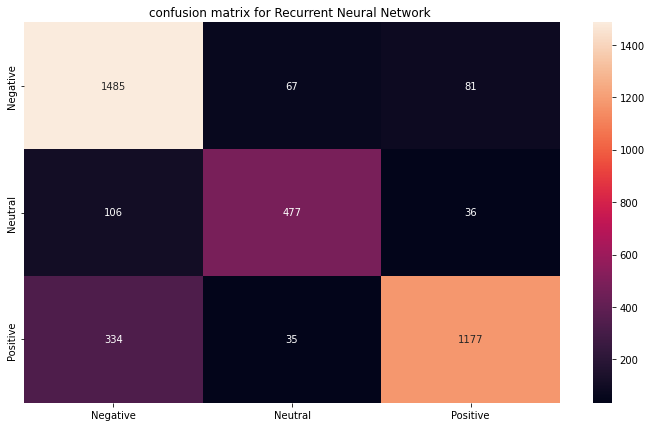

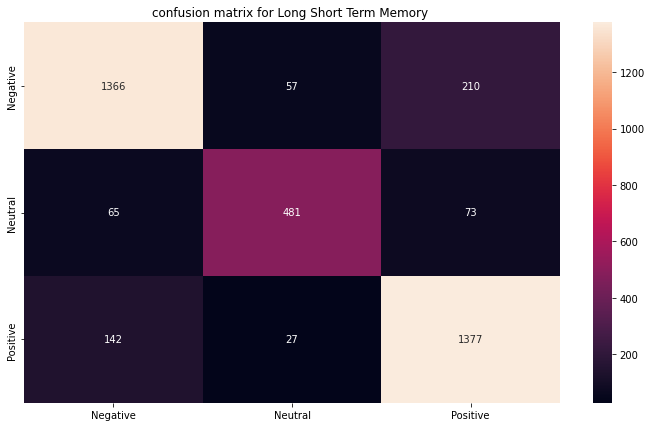

In [ ]:
for i, c in enumerate(classes):
    conf=confusion_matrix(y_test,classes[c])
    cm=pd.DataFrame(
        conf,index=[i for i in labels],
        columns=[i for i in labels]
    )
    plt.figure(figsize=(12,7))
    ax=sns.heatmap(cm,annot=True,fmt='d')
    ax.set_title(f'confusion matrix for {model_names[i]} ')
    plt.show()

In [ ]:
for i, c in enumerate(classes):
    print(f'{model_names[i]}\n',classification_report(y_test,classes[c],target_names=labels))

Artificial Neural Network
               precision    recall  f1-score   support

    Negative       0.76      0.91      0.83      1633
     Neutral       0.86      0.72      0.78       619
    Positive       0.88      0.76      0.81      1546

    accuracy                           0.81      3798
   macro avg       0.83      0.79      0.81      3798
weighted avg       0.82      0.81      0.81      3798

Convolutional Neural Network
               precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      1633
     Neutral       0.87      0.72      0.79       619
    Positive       0.84      0.87      0.86      1546

    accuracy                           0.84      3798
   macro avg       0.85      0.82      0.83      3798
weighted avg       0.85      0.84      0.84      3798

Recurrent Neural Network
               precision    recall  f1-score   support

    Negative       0.77      0.91      0.83      1633
     Neutral       0.82      0.77      0.80   